#Ingestion and Preprocessing of big batches of Flight Data  using Spark on Databricks
<blockquote>
<blockquote>
<blockquote>
    <img src="https://th.bing.com/th/id/OIP.KMInaMkvu2d7dHrp4c7SCgHaEj?rs=1&pid=ImgDetMain" alt="Plane leaving airport">
</blockquote>
</blockquote>
</blockquote>


The pre-processing will follow the 6 Dimensions of Data Quality:  
<img src="https://www.pacificdataintegrators.com/hubfs/Data-quality-dimensions.jpg" alt="The 6 dimensions of data quality" width="200">

## Set up environment & the data

In [0]:
# Fetch flight data
! mkdir data
! wget "https://dataverse.harvard.edu/api/datasets/export?exporter=dataverse_json&persistentId=doi%3A10.7910/DVN/HG7NV7" -O data/metadata.json
! wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/IXITH2" -O data/1987.csv.bz2
! wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/TUYWU3" -O data/1988.csv.bz2
! wget "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/T7EP3M" -O data/1989.csv.bz2
! ls -al data

--2025-03-03 20:39:37--  https://dataverse.harvard.edu/api/datasets/export?exporter=dataverse_json&persistentId=doi%3A10.7910/DVN/HG7NV7
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 52.87.146.127, 52.207.37.59, 52.71.90.186
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|52.87.146.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘data/metadata.json’

data/metadata.json      [ <=>                ]  18.90K  --.-KB/s    in 0s      

2025-03-03 20:39:37 (249 MB/s) - ‘data/metadata.json’ saved [19357]

--2025-03-03 20:39:38--  https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/HG7NV7/IXITH2
Resolving dataverse.harvard.edu (dataverse.harvard.edu)... 52.71.90.186, 52.207.37.59, 52.87.146.127
Connecting to dataverse.harvard.edu (dataverse.harvard.edu)|52.71.90.186|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://dvn

In [0]:
# Unzip the flight data
! for file in data/*.bz2; do [[ -f $file ]] && bzip2 -d "$file" && echo "Unzipped: $file" || echo "No .bz2 files found in the directory."; done
! ls -al data

Unzipped: data/1987.csv.bz2
Unzipped: data/1988.csv.bz2
Unzipped: data/1989.csv.bz2
total 1088640
drwxr-xr-x 2 root root      4096 Mar  3 20:40 .
drwxr-xr-x 1 root root      4096 Mar  3 20:39 ..
-rw-r--r-- 1 root root 127162942 Feb 13  2018 1987.csv
-rw-r--r-- 1 root root 501039472 Feb 13  2018 1988.csv
-rw-r--r-- 1 root root 486518821 Feb 13  2018 1989.csv
-rw-r--r-- 1 root root     19357 Mar  3 20:39 metadata.json


In [0]:

! pip install pyspark==3.5

     

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 316.9 MB 3.0 kB/s 
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425366 sha256=f85f50823f927593506041ce778f495e3c999f9fce18f16e64cd383f7b5775f3
  Stored in directory: /root/.cache/pip/wheels/57/bd/14/ce9e21f2649298678d011fb8f71ed38ee70b42b94fef0be142
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.3.0
    Uninstalling pyspark-3.3.0:
      Successfully uninstalled pyspark-3.3.0
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7e044734-4910-4011-acc2-17c52971d4f7/bin/python -m pip install --upgrade pip' command.


In [0]:
# Set an environment variable
import os
os.environ["SPARK_VERSION"] = "3.5"
print(os.getenv("SPARK_VERSION"))

3.5


In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import col, sum, max as pyspark_max, min, to_timestamp, concat, lit, when, length, substring, lpad, to_date, current_date, year as sp_year, sequence, expr, coalesce

import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from pyspark.serializers import PickleSerializer, AutoBatchedSerializer

In [0]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Data Quality Checks") \
    .getOrCreate()

In [0]:
flights_metadata = spark.read.json("file:/databricks/driver/data/metadata.json")
display(flights_metadata)

authority datasetVersion id identifier persistentUrl protocol publicationDate publisher storageIdentifier 10.7910 List(2008, "Data Expo 2009: Airline on time data", https://doi.org/10.7910/DVN/HG7NV7, Harvard Dataverse, V1, 2008-10-06T19:04:55Z, 60715, doi:10.7910/DVN/HG7NV7, false, List(List(List(2. Data), List(List(MD5, e5cd6860f3ae620b6ccc1d5a24c9734e), application/octet-stream, 2008-10-07, , 1987.csv.bz2, 12652442, 1375005, e5cd6860f3ae620b6ccc1d5a24c9734e, doi:10.7910/DVN/HG7NV7/IXITH2, https://doi.org/10.7910/DVN/HG7NV7/IXITH2, -1, s3://dvn-cloud:17070), 62280, , 1987.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 0be4b20eeb0531c7e328461ce42d9a9c), application/octet-stream, 2008-10-07, , 1988.csv.bz2, 49499025, 1375004, 0be4b20eeb0531c7e328461ce42d9a9c, doi:10.7910/DVN/HG7NV7/TUYWU3, https://doi.org/10.7910/DVN/HG7NV7/TUYWU3, -1, s3://dvn-cloud:17069), 62280, , 1988.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 6141c0c611b92fdf5fdad32a4061c7fc), application/octet-stream, 2008-10-07, , 1989.csv.bz2, 49202298, 1375003, 6141c0c611b92fdf5fdad32a4061c7fc, doi:10.7910/DVN/HG7NV7/T7EP3M, https://doi.org/10.7910/DVN/HG7NV7/T7EP3M, -1, s3://dvn-cloud:17068), 62280, , 1989.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, cbdfb96084323b65595c47f5589e1392), application/octet-stream, 2008-10-07, , 1990.csv.bz2, 52041322, 1375002, cbdfb96084323b65595c47f5589e1392, doi:10.7910/DVN/HG7NV7/QJKL3I, https://doi.org/10.7910/DVN/HG7NV7/QJKL3I, -1, s3://dvn-cloud:17067), 62280, , 1990.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 854cf258d42b6663f373a49986a98cff), application/octet-stream, 2008-10-07, , 1991.csv.bz2, 49877448, 1375001, 854cf258d42b6663f373a49986a98cff, doi:10.7910/DVN/HG7NV7/EJ4WJO, https://doi.org/10.7910/DVN/HG7NV7/EJ4WJO, -1, s3://dvn-cloud:17064), 62280, , 1991.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 2d744403ee4280d4044c494db17edc98), application/octet-stream, 2008-10-07, , 1992.csv.bz2, 50040946, 1375000, 2d744403ee4280d4044c494db17edc98, doi:10.7910/DVN/HG7NV7/PLPDQO, https://doi.org/10.7910/DVN/HG7NV7/PLPDQO, -1, s3://dvn-cloud:17062), 62280, , 1992.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, deb91bafad00b8f40609553349539545), application/octet-stream, 2008-10-07, , 1993.csv.bz2, 50111774, 1374999, deb91bafad00b8f40609553349539545, doi:10.7910/DVN/HG7NV7/IOU9DX, https://doi.org/10.7910/DVN/HG7NV7/IOU9DX, -1, s3://dvn-cloud:17060), 62280, , 1993.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, d2ca7209c75ee572f9033d620041327c), application/octet-stream, 2008-10-07, , 1994.csv.bz2, 51123887, 1374998, d2ca7209c75ee572f9033d620041327c, doi:10.7910/DVN/HG7NV7/BH5P0X, https://doi.org/10.7910/DVN/HG7NV7/BH5P0X, -1, s3://dvn-cloud:17057), 62280, , 1994.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 949dea36c5cfde671325ba52ff86cb2f), application/octet-stream, 2008-10-07, , 1995.csv.bz2, 74881752, 1374997, 949dea36c5cfde671325ba52ff86cb2f, doi:10.7910/DVN/HG7NV7/ZLTTDC, https://doi.org/10.7910/DVN/HG7NV7/ZLTTDC, -1, s3://dvn-cloud:17055), 62280, , 1995.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 7af30b0699a490b759fa9d39ed507174), application/octet-stream, 2008-10-07, , 1996.csv.bz2, 75887707, 1374996, 7af30b0699a490b759fa9d39ed507174, doi:10.7910/DVN/HG7NV7/3KDWWL, https://doi.org/10.7910/DVN/HG7NV7/3KDWWL, -1, s3://dvn-cloud:17054), 62280, , 1996.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 41bd1e5e7916ec6d6722ec9002d526ca), application/octet-stream, 2008-10-07, , 1997.csv.bz2, 76705687, 1374995, 41bd1e5e7916ec6d6722ec9002d526ca, doi:10.7910/DVN/HG7NV7/RUGDRW, https://doi.org/10.7910/DVN/HG7NV7/RUGDRW, -1, s3://dvn-cloud:17053), 62280, , 1997.csv.bz2, false, 1), List(List(2. Data), List(List(MD5, 442ce082e94021d3def5311ac75b9066), application/octet-stream, 2008-10-07, , 1998.csv.bz2, 76683506, 1374994, 442ce082e94021d3def5311ac75b9066, doi:10.7910/DVN/HG7NV7/H07RX8, https://doi.org/10.7910/DVN/HG7NV7/H07RX8, -1, s3://dvn-cloud:17052), 6

In [0]:
schema = StructType(
    [
        StructField('Year', IntegerType()),
        StructField('Month', IntegerType()),
        StructField('DayofMonth', IntegerType()),
        StructField('DayOfWeek', IntegerType()),
        StructField('DepTime', IntegerType()),
        StructField('CRSDepTime', IntegerType()),
        StructField('ArrTime', IntegerType()),
        StructField('CRSArrTime', IntegerType()),
        StructField('UniqueCarrier', StringType()),
        StructField('FlightNum', IntegerType()),
        StructField('TailNum', IntegerType()),
        StructField('ActualElapsedTime', IntegerType()),
        StructField('CRSElapsedTime', IntegerType()),
        StructField('AirTime', IntegerType()),
        StructField('ArrDelay', IntegerType()),
        StructField('DepDelay', IntegerType()),
        StructField('Origin', StringType()),
        StructField('Dest', StringType()),
        StructField('Distance', IntegerType()),
        StructField('TaxiIn', IntegerType()),
        StructField('TaxiOut', IntegerType()),
        StructField('Cancelled', IntegerType()),
        StructField('CancellationCode', StringType()),
        StructField('Diverted', IntegerType()),
        StructField('CarrierDelay', IntegerType()),
        StructField('WeatherDelay', IntegerType()),
        StructField('NASDelay', IntegerType()),
        StructField('SecurityDelay', IntegerType()),
        StructField('LateAircraftDelay', IntegerType())
    ]
)

In [0]:
year = 1987
flights_1987 = spark.read.csv(f"file:/databricks/driver/data/{year}.csv", header=True, schema=schema)
display(flights_1987)

Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay 1987 10 14 3 741 730 912 849 PS 1451 null 91 79 null 23 11 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 15 4 729 730 903 849 PS 1451 null 94 79 null 14 -1 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 17 6 741 730 918 849 PS 1451 null 97 79 null 29 11 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 18 7 729 730 847 849 PS 1451 null 78 79 null -2 -1 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 19 1 749 730 922 849 PS 1451 null 93 79 null 33 19 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 21 3 728 730 848 849 PS 1451 null 80 79 null -1 -2 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 22 4 728 730 852 849 PS 1451 null 84 79 null 3 -2 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 23 5 731 730 902 849 PS 1451 null 91 79 null 13 1 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 24 6 744 730 908 849 PS 1451 null 84 79 null 19 14 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 25 7 729 730 851 849 PS 1451 null 82 79 null 2 -1 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 26 1 735 730 904 849 PS 1451 null 89 79 null 15 5 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 28 3 741 725 919 855 PS 1451 null 98 90 null 24 16 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 29 4 742 725 906 855 PS 1451 null 84 90 null 11 17 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 31 6 726 725 848 855 PS 1451 null 82 90 null -7 1 SAN SFO 447 null null 0 NA 0 null null null null null 1987 10 1 4 936 915 1035 1001 PS 1451 null 59 46 null 34 21 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 2 5 918 915 1017 1001 PS 1451 null 59 46 null 16 3 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 3 6 928 915 1037 1001 PS 1451 null 69 46 null 36 13 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 4 7 914 915 1003 1001 PS 1451 null 49 46 null 2 -1 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 5 1 1042 915 1129 1001 PS 1451 null 47 46 null 88 87 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 6 2 934 915 1024 1001 PS 1451 null 50 46 null 23 19 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 7 3 946 915 1037 1001 PS 1451 null 51 46 null 36 31 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 8 4 932 915 1033 1001 PS 1451 null 61 46 null 32 17 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 9 5 947 915 1036 1001 PS 1451 null 49 46 null 35 32 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 10 6 915 915 1022 1001 PS 1451 null 67 46 null 21 0 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 11 7 916 915 1006 1001 PS 1451 null 50 46 null 5 1 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 12 1 944 915 1027 1001 PS 1451 null 43 46 null 26 29 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 13 2 941 915 1036 1001 PS 1451 null 55 46 null 35 26 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 14 3 930 915 1029 1001 PS 1451 null 59 46 null 28 15 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 15 4 920 915 1023 1001 PS 1451 null 63 46 null 22 5 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 17 6 1009 915 1104 1001 PS 1451 null 55 46 null 63 54 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 18 7 915 915 1008 1001 PS 1451 null 53 46 null 7 0 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 19 1 940 915 1032 1001 PS 1451 null 52 46 null 31 25 SFO RNO 192 null null 0 NA 0 null null null null null 1987 10 21 3 913 915 1003 1001 PS 1451 null 50 46 null 2 -2 SFO RNO 

In [0]:
flights_1987.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true

In [0]:
display(flights_1987.describe())

summary Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum TailNum ActualElapsedTime CRSElapsedTime AirTime ArrDelay DepDelay Origin Dest Distance TaxiIn TaxiOut Cancelled CancellationCode Diverted CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay count 1311826 1311826 1311826 1311826 1292141 1311826 1288326 1311826 1311826 1311826 0 1288326 1311826 0 1288326 1292141 1311826 1311826 1310811 0 0 1311826 1311826 1311826 0 0 0 0 0 mean 1987.0 10.993736211967136 15.717608890203426 3.9490427846375966 1369.2755101803905 1361.130906080532 1493.1515555845338 1491.0518346183107 null 670.1427125243745 null 102.17902999706595 100.61908515306146 null 9.446699049774669 8.063637791850889 null null 591.2441015523978 null null 0.015005801074227831 null 0.0029081600761076544 null null null null null stddev 5.779684178325132E-14 0.8232011620414477 8.835639995196614 1.9862897256015322 478.71827909060164 471.97010286925854 498.7502519479945 486.80020332505114 null 514.5509515450487 null 61.82632480451613 61.23218933935592 null 25.825531327094584 24.024794200929037 null null 498.1205841696644 null null 0.1215756483658352 null 0.05384890798812429 null null null null null min 1987 10 1 1 1 1 1 1 AA 1 null -515 -40 null -1302 -1345 ABE ABE 0 null null 0 NA 0 null null null null null max 1987 12 31 7 2400 2359 2400 2400 WN 6282 null 1654 1555 null 1033 1439 YUM YUM 4983 null null 1 NA 1 null null null null null

##Data Completeness

In [0]:
complete_df = flights_1987
for column in flights_1987.columns:
    if flights_1987.select(sum(col(column).isNotNull().cast('int'))).first()[0] == 0:
        complete_df = complete_df.drop(column)
        print(f"Dropped column {column}")

display(complete_df.describe())

Dropped column TailNum
Dropped column AirTime
Dropped column TaxiIn
Dropped column TaxiOut
Dropped column CarrierDelay
Dropped column WeatherDelay
Dropped column NASDelay
Dropped column SecurityDelay
Dropped column LateAircraftDelay


summary Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum ActualElapsedTime CRSElapsedTime ArrDelay DepDelay Origin Dest Distance Cancelled CancellationCode Diverted count 1311826 1311826 1311826 1311826 1292141 1311826 1288326 1311826 1311826 1311826 1288326 1311826 1288326 1292141 1311826 1311826 1310811 1311826 1311826 1311826 mean 1987.0 10.993736211967136 15.717608890203426 3.9490427846375966 1369.2755101803905 1361.130906080532 1493.1515555845338 1491.0518346183107 null 670.1427125243745 102.17902999706595 100.61908515306146 9.446699049774669 8.063637791850889 null null 591.2441015523978 0.015005801074227831 null 0.0029081600761076544 stddev 5.779684178325132E-14 0.8232011620414477 8.835639995196614 1.9862897256015322 478.71827909060164 471.97010286925854 498.7502519479945 486.80020332505114 null 514.5509515450487 61.82632480451613 61.23218933935592 25.825531327094584 24.024794200929037 null null 498.1205841696644 0.1215756483658352 null 0.05384890798812429 min 1987 10 1 1 1 1 1 1 AA 1 -515 -40 -1302 -1345 ABE ABE 0 0 NA 0 max 1987 12 31 7 2400 2359 2400 2400 WN 6282 1654 1555 1033 1439 YUM YUM 4983 1 NA 1

In [0]:
with_nulls = []
for column in complete_df.columns:
    null_count = complete_df.select(sum(col(column).isNull().cast('int'))).first()[0]
    null_percent = null_count/complete_df.count()
    if null_count > 0:
        with_nulls.append({column:[null_count,null_percent]})

with_nulls

Out[18]: [{'DepTime': [19685, 0.015005801074227831]},
 {'ArrTime': [23500, 0.017913961150335486]},
 {'ActualElapsedTime': [23500, 0.017913961150335486]},
 {'ArrDelay': [23500, 0.017913961150335486]},
 {'DepDelay': [19685, 0.015005801074227831]},
 {'Distance': [1015, 0.0007737306624506603]}]

In [0]:
complete_df = complete_df.dropna()
display(complete_df.describe())

summary Year Month DayofMonth DayOfWeek DepTime CRSDepTime ArrTime CRSArrTime UniqueCarrier FlightNum ActualElapsedTime CRSElapsedTime ArrDelay DepDelay Origin Dest Distance Cancelled CancellationCode Diverted count 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 1287333 mean 1987.0 10.986200928586465 15.695072681272057 3.9560098280709033 1369.2337382790622 1361.1295173820604 1493.1986595542878 1491.2432540764512 null 669.1307245289291 102.19723568027852 100.63129508837262 9.445402238581625 7.967690566465708 null null 591.271075160817 0.0 null 0.0 stddev 0.0 0.8225078999372174 8.844664421320461 1.9828404368245844 478.62742789843344 471.8751486458204 498.8031731428228 486.5346204623562 null 513.3674875342418 61.83923780051658 61.212815862073136 25.81079576862539 23.636863409186795 null null 498.2503614020822 0.0 null 0.0 min 1987 10 1 1 1 1 1 1 AA 1 -515 -40 -1302 -1345 ABE ABE 10 0 NA 0 max 1987 12 31 7 2400 2359 2400 2400 WN 6282 1654 1440 1033 1439 YUM YUM 4983 0 NA 0

##Data Accuracy

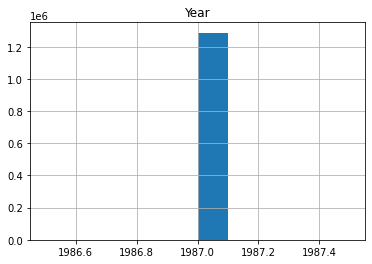

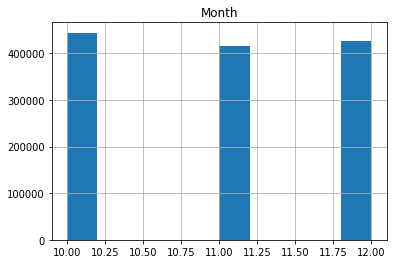

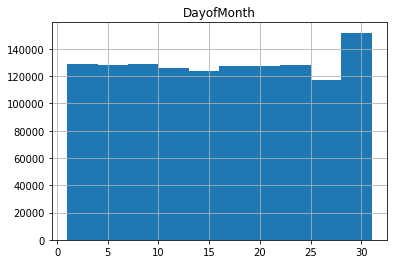

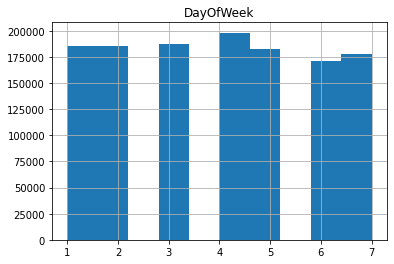

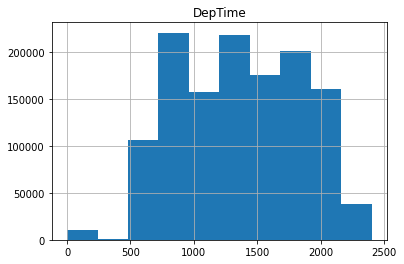

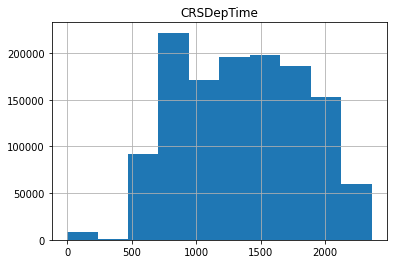

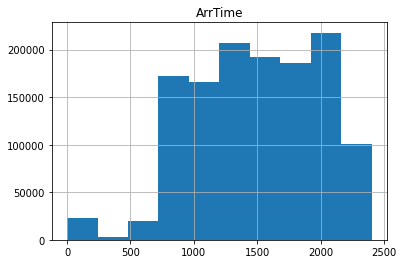

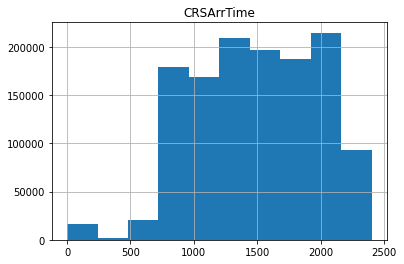

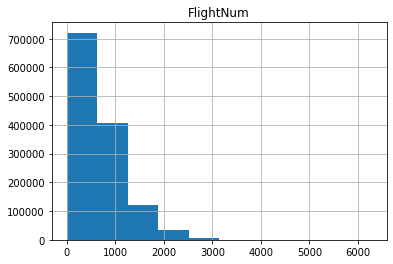

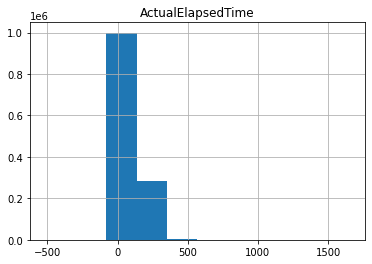

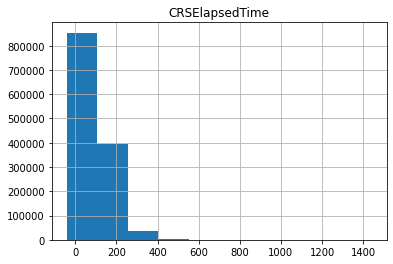

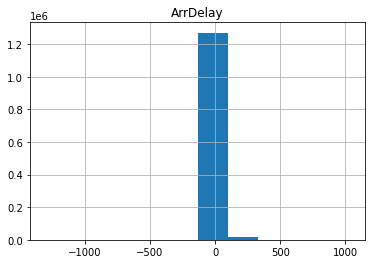

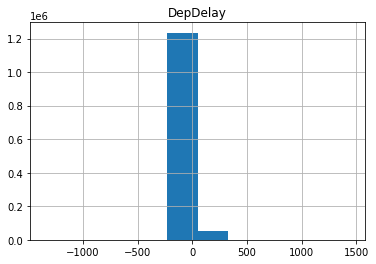

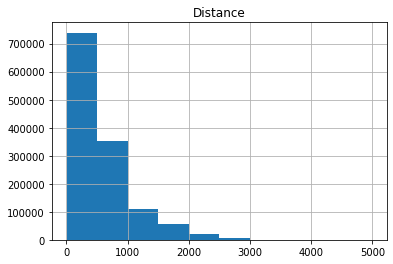

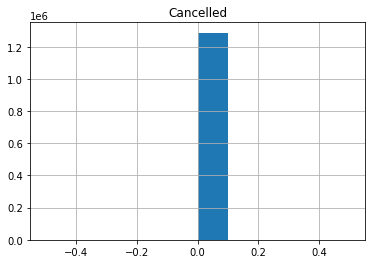

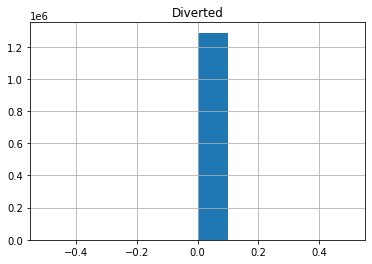

In [0]:
for column in complete_df.columns:
    if complete_df.schema[column].dataType == IntegerType():
        pd_df = complete_df.select(col(column)).toPandas()

        pd_df.hist()
        plt.show()

##Data Consistency

In [0]:
string_columns = []
for column in complete_df.columns:
  if complete_df.schema[column].dataType == StringType():
    string_columns.append(column)

string_columns

Out[21]: ['UniqueCarrier', 'Origin', 'Dest', 'CancellationCode']

In [0]:
for column in string_columns:
    complete_df.groupBy(column).count().select(column).sort(column).show()

+-------------+
|UniqueCarrier|
+-------------+
|           AA|
|           AS|
|           CO|
|           DL|
|           EA|
|           HP|
|           NW|
|       PA (1)|
|           PI|
|           PS|
|           TW|
|           UA|
|           US|
|           WN|
+-------------+

+------+
|Origin|
+------+
|   ABE|
|   ABQ|
|   ACV|
|   AGS|
|   ALB|
|   ALO|
|   AMA|
|   ANC|
|   APF|
|   ATL|
|   ATW|
|   AUS|
|   AVL|
|   AVP|
|   AZO|
|   BDL|
|   BET|
|   BFL|
|   BGM|
|   BGR|
+------+
only showing top 20 rows

+----+
|Dest|
+----+
| ABE|
| ABQ|
| ACV|
| AGS|
| ALB|
| ALO|
| AMA|
| ANC|
| APF|
| ATL|
| ATW|
| AUS|
| AVL|
| AVP|
| AZO|
| BDL|
| BET|
| BFL|
| BGM|
| BGR|
+----+
only showing top 20 rows

+----------------+
|CancellationCode|
+----------------+
|              NA|
+----------------+



##Data Uniqueness

In [0]:
# Number of identical rows
complete_df.groupBy(complete_df.columns).count().where(col("count") > 1).count()

Out[23]: 69

In [0]:
#Drop identical rows
unique_rows = complete_df.dropDuplicates()
unique_rows.groupBy(unique_rows.columns).count().where(col("count") > 1).count()

Out[24]: 0

In [0]:
#Duplicates based on compound primary key (origin airport, the carrier, flight number, scheduled departure datetime)
primary_key_fields = ["Origin", "UniqueCarrier","FlightNum","DepTime_Timestamp"]

unique_rows\
    .withColumn("DepTime_Hour", when(substring(col("DepTime").cast(StringType()),1,2) == "24", lit("00")).when(length(col("DepTime").cast(StringType())) < 3, lit("00")).when(length(col("DepTime").cast(StringType())) == 3, substring(col("DepTime").cast(StringType()),1,1)).otherwise(substring(col("DepTime").cast(StringType()),1,2)))\
        .withColumn("DepTime_Min", substring(col("DepTime").cast(StringType()),-2,2))\
            .withColumn("DepTime_Timestamp",to_timestamp(
                    concat(
                        col("Year"), lit("-"), 
                        lpad(col("Month"), 2, "0"), lit("-"), 
                        lpad(col("DayofMonth"), 2, "0"), lit(" "), 
                        lpad(col("DepTime_Hour"), 2, "0"), lit(":"), 
                        lpad(col("DepTime_Min"), 2, "0")
                    ), 
                    "yyyy-MM-dd HH:mm"
                ))\
            .groupBy(primary_key_fields).count()\
        .where(col("count") > 1)\
    .count()

Out[25]: 0

## Data Validity

In [0]:
# Define multiple checks
current_year = sp_year(current_date())

# Check if Year is less than current year
year_check_fail = unique_rows.filter(~(col("Year") < current_year))
print("Year Check Failures:")
if year_check_fail.count() > 0:
    year_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if Month is between 1 and 12
month_check_fail = unique_rows.filter(~((col("Month") >= 1) & (col("Month") <= 12)))
print("Month Check Failures:")
if month_check_fail.count() > 0:
    month_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if DayofMonth is between 1 and 31
dayofmonth_check_fail = unique_rows.filter(~((col("DayofMonth") >= 1) & (col("DayofMonth") <= 31)))
print("DayofMonth Check Failures:")
if dayofmonth_check_fail.count() > 0:
    dayofmonth_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if DayOfWeek is between 1 and 7
dayofweek_check_fail = unique_rows.filter(~((col("DayOfWeek") >= 1) & (col("DayOfWeek") <= 7)))
print("DayOfWeek Check Failures:")
if dayofweek_check_fail.count() > 0:
    dayofweek_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if DepTime is between 1 and 2400
deptime_check_fail = unique_rows.filter(~((col("DepTime") >= 1) & (col("DepTime") <= 2400)))
print("DepTime Check Failures:")
if deptime_check_fail.count() > 0:
    deptime_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if CRSDepTime is between 1 and 2400
crsdeptime_check_fail = unique_rows.filter(~((col("CRSDepTime") >= 1) & (col("CRSDepTime") <= 2400)))
print("CRSDepTime Check Failures:")
if crsdeptime_check_fail.count() > 0:
    crsdeptime_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if ArrTime is between 1 and 2400
arrtime_check_fail = unique_rows.filter(~((col("ArrTime") >= 1) & (col("ArrTime") <= 2400)))
print("ArrTime Check Failures:")
if arrtime_check_fail.count() > 0:
    arrtime_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if CRSArrTime is between 1 and 2400
crsarrtime_check_fail = unique_rows.filter(~((col("CRSArrTime") >= 1) & (col("CRSArrTime") <= 2400)))
print("CRSArrTime Check Failures:")
if crsarrtime_check_fail.count() > 0:
    crsarrtime_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if FlightNum is greater than 0
flightnum_check_fail = unique_rows.filter(~(col("FlightNum") > 0))
print("FlightNum Check Failures:")
if flightnum_check_fail.count() > 0:
    flightnum_check_fail.show()
else:
    print("All rows meet the validity criteria \n")

# Check if Distance is greater than 0
distance_check_fail = unique_rows.filter(~(col("Distance") > 0))
print("Distance Check Failures:")
if distance_check_fail.count() > 0:
    distance_check_fail.show()
else:
    print("All rows meet the validity criteria \n")


Year Check Failures:
All rows meet the validity criteria 

Month Check Failures:
All rows meet the validity criteria 

DayofMonth Check Failures:
All rows meet the validity criteria 

DayOfWeek Check Failures:
All rows meet the validity criteria 

DepTime Check Failures:
All rows meet the validity criteria 

CRSDepTime Check Failures:
All rows meet the validity criteria 

ArrTime Check Failures:
All rows meet the validity criteria 

CRSArrTime Check Failures:
All rows meet the validity criteria 

FlightNum Check Failures:
All rows meet the validity criteria 

Distance Check Failures:
All rows meet the validity criteria 



## Data Timeliness

In [0]:
# Flight count per day
range_rows = unique_rows\
    .withColumn("DepTime_Date",to_timestamp(
        concat(
            col("Year"), lit("-"), 
            lpad(col("Month"), 2, "0"), lit("-"), 
            lpad(col("DayofMonth"), 2, "0")
        ), 
        "yyyy-MM-dd"
    ))\
    .groupBy(
        col("DepTime_Date")
    ).count().sort(col("DepTime_Date"))

In [0]:
# Get minimum and maximum date from DepTime_Date
min_date = range_rows.agg(min("DepTime_Date")).collect()[0][0]
max_date = range_rows.agg(pyspark_max("DepTime_Date")).collect()[0][0]

# Create a continuous series of dates from min_date to max_date
date_range = spark.range(0, (max_date - min_date).days + 1).select(
    expr("date_add('{}', cast(id as int)) as days".format(min_date))
)

# Add count column with all values set to 0 in t2 DataFrame
t2 = date_range.withColumn("count", lit(0))

# Alias the count columns to disambiguate them
range_rows = range_rows.withColumnRenamed("count", "range_count")
t2 = t2.withColumnRenamed("count", "t2_count")

# Perform the left join and add the range_rows.count values to t2.count
result = t2.join(range_rows, t2.days == range_rows.DepTime_Date, "left") \
    .withColumn("count", col("t2_count") + coalesce(range_rows["range_count"], lit(0))) \
    .select(t2["days"], col("count"))

# Show the result
print("Days with no flight data:")
result.where(col("count") == 0).show()

Days with no flight data:
+----+-----+
|days|count|
+----+-----+
+----+-----+



## Storing the cleaned data

In [0]:
rdd = unique_rows.rdd._reserialize(AutoBatchedSerializer(PickleSerializer()))
obj = rdd.ctx._jvm.org.apache.spark.mllib.api.python.SerDe.pythonToJava(rdd._jrdd, True)
size = sc._jvm.org.apache.spark.util.SizeEstimator.estimate(obj)
size_MB = size/1000000
partitions = max(int(size_MB/200), 2)
print(f'The dataframe is {size_MB} MB')

The dataframe is 47.580352 MB


In [0]:
#repartition dataframe and write to parquet
coalesced_df = unique_rows.coalesce(partitions)

coalesced_df.write.parquet(f"./preprocessed_flight_data_{year}")